In [18]:
##### This code is from Updated Testing Reddit - No Con- bias (Fictitious Play)-01092022
##### This code replace the big real datanetwork with small sythetic network 
import scipy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import time
import random
from scipy.stats import beta
import pandas as pd
import copy
%matplotlib inline
%run config_file.ipynb
#%run pure_strategy_selection.ipynb  #include simple selection algorithm
import scipy.io
import collections
import sys
from itertools import count
from itertools import combinations
from itertools import product
import scipy.optimize
import csv
import os.path
from math import comb


np.set_printoptions(precision=3)
save_path = 'C:/Users/xzhan176/OneDrive/Misinfo Paper/K Nodes - All/Sythetic Network - less memory version/'



    # Fixed initial condition + memeory = 50

## Mathmatic Functions

In [ ]:
# centers the opinion vector around 0\n",
def mean_center(op, n):
    ones = np.ones((n, 1))
    x = op - (np.dot(np.transpose(op),ones)/n) * ones
    return x
    
# compute number of edges, m\n
def num_edges(L, n):
    m = 0
    for i in range(n):
        for j in range(n):
            if i > j and L[i,j] < 0:
                m += 1            
    return m

# Compute number of possible actions
def len_actions(k, n):
    # create all combination of K opinions
    max_option = [0, 1]
    
    k_opinions =list(product(max_option, repeat=k))  # All k opinion combinations
    len_kops = len(k_opinions) # - number of combinations exist
    # Horizontal length of all possible actions
    h = comb(n,k) * len_kops
    return h


# maximizing polarization only: \\bar{z}^T \\bar{z}   
def obj_polarization(A, L, op, n):
    op_mean = mean_center(op, n)
    z_mean = np.dot(A, op_mean)
    return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# def obj_polarization_1(A, L, op, n):  #z_mean is the same as s_mean - according to Stanford paper theory
#     z = np.dot(A, op) 
#     z_mean = mean
#     return np.dot(np.transpose(z_mean), z_mean)[0,0] 

# Calculate innate polarization
def obj_innate_polarization(s, n):  
#     np.set_printoptions(precision=5)
    op_mean = mean_center(s, n)
    return np.dot(np.transpose(op_mean), op_mean)[0,0]

np.set_printoptions(precision=5)

In [2]:
########### create all combination
def cgen(i,n,k):
    """
    returns the i-th combination of k numbers chosen from 1,2,...,n
    """
    c = []
    r = i+0
    j = -1
    for s in range(1,k+1):
        j = j+1
        while r-comb(n-1-j,k-s)>=0:
            r -= comb(n-1-j,k-s)
            j += 1
        c.append(j)
    return c


########## input representative k_nodes, nodes needs to be excluded, return the real k nodes that are available 
def convert_available(k_nodes, touched, k):
    #touched = list(set(touched)) #[2,4,6,8] unqie values of touched
    touched.sort()
    for i in touched: 
        for j in range(k): #[2,3,4,5,6,7,8,9]   
            if k_nodes[j]>=i:
                k_nodes[j] = k_nodes[j] + 1
    return k_nodes

########### create available combination of K nodes
def creat_available_comb(i_th, n,k,touched):

    a = len(set(touched))  # number of unqiue touched nodes
    len_nodesets = comb(n-a,k) #  number of available combination of k nodes
    
    k_fake = cgen(i_th,n-a,k) # generate the i-th list from total n-a agents
    k_nodes = convert_available(k_fake, touched, k) # convert the i-th list to real k nodes

    return (k_nodes)

# def creat_all_comb(i_th, n, k):
# ########### create all combination of K opinions
#     max_option = [0, 1]
#     k_opinions =[]
#     k_opinions = product(max_option, repeat=k)  # - all k opinion combinations

#     k_nodes = cgen(i_th,n,k)
    
#     return(k_nodes, k_opinions)

def creat_all_comb(k):
########### create all combination of K opinions
    max_option = [0, 1]
    k_opinions =[]
    k_opinions = product(max_option, repeat=k)  # - all k opinion combinations
    
    return list(k_opinions)


def change_k_innate_opinion(s, node_set, k_opinion): # node_set - 1 set  k_opinion- 1 set
    op =  copy.copy(s) # make a copy of the innate opinion array 

    for j in range(k):
        b = node_set[j] # b - agent index
#         print('agent index' + str(b))
#         print('op length'+ str(len(op)))
#         print('k_opinions'+str(list(k_opinions)))
        op[b]=k_opinion[j]   # f - index of which opinion combination

    return op

def create_erdos_renyi_network(n, p, u, v):
    A = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
#         for j in range(i+1,n):
#             r = np.random.rand()
#             if r < p:
            if j<i:
                A[i,j] = A[j,i] = 1
#             if i==u or i==v:
#                 A[i,j] = A[j,i] = 1
    return A

# Create a synthetic Erdős-Rényi network with 10 nodes and edge probability 0.3
# p = 0.3
# u=1
# v=2

# print(s)
# # Print the adjacency matrix
# G = create_erdos_renyi_network(n, p, u, v)
# print(G)

def make_innat_opinions(n): # Make opinion for agents only - no info source is involved
    
    # Make list of ind innate opinion to define info source opinion
    innat_s = np.random.uniform(low=0, high=1, size=int(n))   #individual's innate opinion 

    s = np.zeros((n, 1))
    
    idx1 = 0
    for i in range(len(s)):
        s[i] = innat_s[idx1]  #set innate opinion for ind.
        idx1 += 1  
    return s




### 1. Import Network

In [19]:
# # Import network data
def import_network(network): #1-karate; 2-Reddit; 3-Twitter; 4-Synthetic net1; 5-Synthetic net2;
    if network ==1:
        %run Karate.ipynb
    if network ==2:
        %run Reddit.ipynb
    if network ==3:
        %run Twitter.ipynb
    if network ==4:
        df = pd.read_csv (save_path+'data/network1.csv', header=None)
        G = np.array(df[df.columns[:]])
        # # # print(G)
        df1 = pd.read_csv(save_path+'Data/Innate Opinion.csv', header = None)
        s = np.array(df1[df1.columns[:]])
        n = len(s)
    if network == 5:
        df = pd.read_csv (save_path+'data/network2.csv', header=None)
        G = np.array(df[df.columns[:]])
        # # # print(G)
        df1 = pd.read_csv(save_path+'Data/Innate Opinion.csv', header = None)
        s = np.array(df1[df1.columns[:]])
        n = len(s)
    if network ==6:
        df = pd.read_csv (save_path+'data/Adjacency Matrix.csv', header=None)
        G = np.array(df[df.columns[:]])
        # # # print(G)
        df1 = pd.read_csv(save_path+'Data/Innate Opinion.csv', header = None)
        s = np.array(df1[df1.columns[:]])
        n = len(s)
    if network ==6:
        s = make_innat_opinions(n)
        print(s)

        # Create empty graph
        nxG = nx.Graph()
        # Add nodes to graph
        nxG.add_nodes_from(range(n))

        # Add edges based on node index
        for i in range(n):
            for j in range(i):
                p = (n-i)/(n-j) # Probability of edge existing
                if np.random.random() < p:
                    nxG.add_edge(i, j)
        #Draw graph
        nx.draw(nxG, with_labels=True)
        plt.show()   
        
import_network(network)

There are 34 agents
[[0. 1. 1. ... 1. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 0. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [37]:
################## Process the Network Data
L = scipy.sparse.csgraph.laplacian(G, normed=False)  # Return the Laplacian matrix
A = np.linalg.inv(np.identity(n) + L)  # A = (I + L)^(-1)\n  Chen's paper theory
m = num_edges(L, n)                    # call the function to calculate the number of edges
# what the twitter graph looks like 
nxG = nx.from_numpy_matrix(G)          
#plt.figure(figsize=(20, 20))
# nx.draw(nxG).
columnsum_ij = np.sum(A, axis=0)
print(columnsum_ij)
# handmade innate opinion, everyone neutral
# s = [0.5]*n
# s = np.reshape(s, (n, 1))
# print(s)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<Figure size 2000x2000 with 0 Axes>

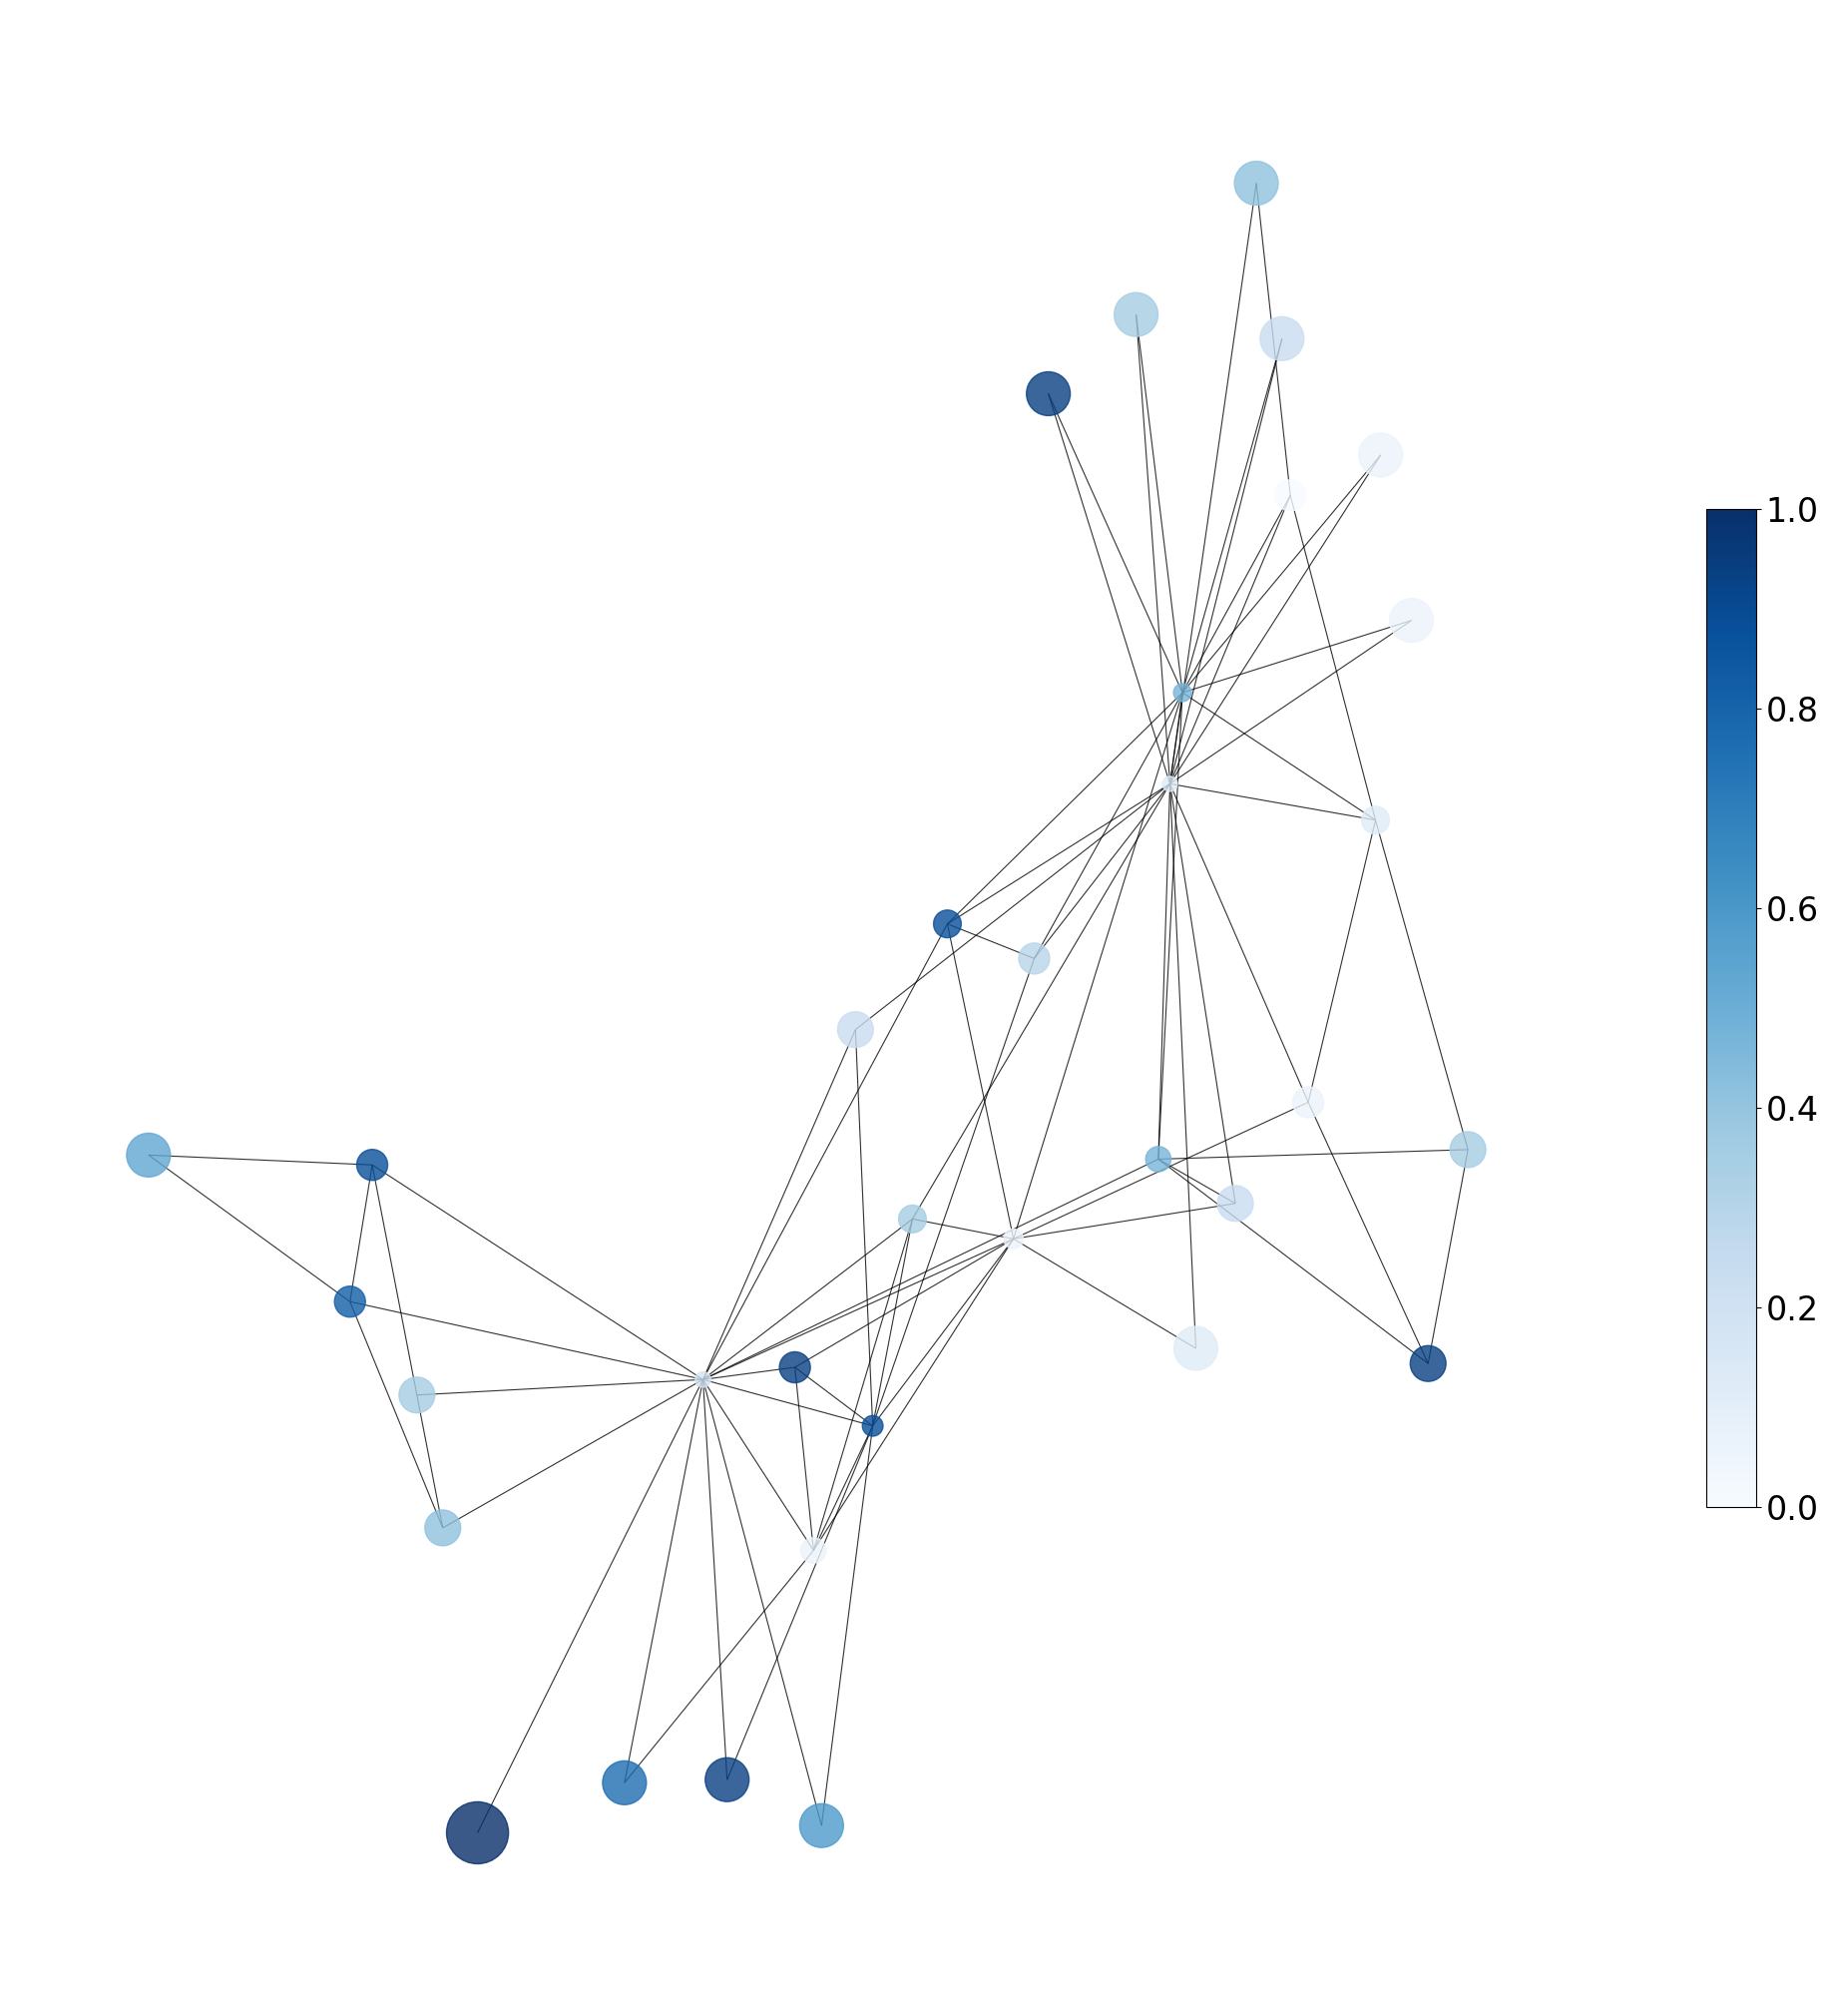

In [38]:
# what the twitter graph looks like 
s_use = s.flatten()   # Convert array to a list for later operation
s_use = s_use.tolist()
new_s = [i * 30 for i in s_use]
df = pd.DataFrame(new_s, columns=['Opinion']) #create a dataframe with index at column 1, opinion at column 2
#_______________________________________________________

nxG = nx.from_numpy_matrix(G)   
# nxG = nx.relabel_nodes(nxG, mapping)      
plt.figure(figsize=(20, 20))


def node_edge(G, n):
    edges =[]
    for v in range(n):
        a = np.array(np.nonzero(G[v])[0])
        edge = len(a)
#         print(edge)
        edges.append(edge)
        
    return edges

node_edges = node_edge(G, n)
# print(node_edges)

node_sizes =[]
for i in node_edges:
    node_size = 1/i*2000
    node_sizes.append(node_size)

min_equi = []
max_equi = []
# Create node color
color_map = []
for node in nxG:
    if node in min_equi:
        color_map.append('orange')
    elif node in max_equi:
        color_map.append('red')
    else:
        color_map.append('grey')
# print(node_sizes)
#-_______________________________________
# what the twitter graph looks like 
nxG = nx.from_numpy_matrix(G)          
plt.figure(figsize=(20, 20))

# Fix seed - fix network shape
my_pos = nx.spring_layout(nxG, seed = 2)
nx.draw(nxG, pos= my_pos, with_labels= False, node_color=df['Opinion'].astype(int),cmap=plt.cm.Blues, node_size= node_sizes, edge_color='black', width=0.8, font_color='black',font_size=26, font_weight='bold', alpha=0.8)
#nx.draw(nxG, pos = my_pos, with_labels=False, node_color=color_map, node_size= node_sizes, edge_color='grey', width=0.5, font_color='white',font_size=9, font_weight='bold')
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin = 0, vmax=1))
cbar = plt.colorbar(sm, shrink = 0.5)
tick_font_size = 24
cbar.ax.tick_params(labelsize=tick_font_size)
plt.show()

# print(s)

### 2. Equilibrium & Polarization 
$$P(z) = z ^T * z $$


In [39]:
# op = s
# y = mean_center(s,n)
# # print(y)
# innat_pol = np.dot(np.transpose(y), y)[0,0] 
# print('Innate_polarization:')
# print(innat_pol)

# # Test equilibrium polarization
# equ_pol = obj_polarization(A, L, s, n)
# print('Equi_polarization:')
# print(equ_pol)

# di = equ_pol-innat_pol
# print("Difference:")
# print(di)

### 3. Helper Functions

In [40]:
def k_random_play(s,n,k):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)
    
    ########### create all combination of K nodes
    k_opinions = creat_all_comb(k)
    len_nodesets = comb(n,k)

    i_th = random.randint(0,len_nodesets-1)  # randomly select an agent index
    v_list = cgen(i_th,n,k)
    
    ########### create all combination of K opinions
    len_kops = len(k_opinions) # - number of combinations exist
    op_index = random.randint(0,len_kops-1) # randomly select index for an OPINION list 
    new_op = k_opinions[op_index]  # randomly select an opininon list(0 and 1) to update the opinion array
#     print('Nodes, opinions')
#     print(v_list,new_op)
#     print(new_op)
    op = change_k_innate_opinion(s, v_list, new_op)

   # print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    
    por = obj_polarization(A, L, op, n)

#     print("Network reaches stead_state Polarization: " + str(por))

    return (v_list, new_op, por)


In [41]:
def k_random_play_1(s,n,k,max_touched):  # player randomly choose an agent and randomly change the agent
    
    op = copy.copy(s)
#     max_opi_option = random.uniform(0, 1)   # options that maximizer have

    a = len(set(max_touched))  # number of unqiue touched nodes
    len_nodesets = comb(n-a,k) #  number of available combination of k nodes
    
    i_th = random.randint(0,len_nodesets-1)  # randomly select an action index
    v_list = creat_available_comb(i_th, n,k,max_touched)
  
    new_op_list = []
    for i in range(k):
        #new_op = random.uniform(0, 1)  # randomly select an opininon between 0 and 1
        new_op = 0.5
        new_op_list.append(new_op)
   
    new_op_list = tuple(new_op_list)
#     print('Nodes, opinions')
#     print(v_list,new_op_list)
    op = change_k_innate_opinion(s, v_list, new_op_list)
   # print("    "+"Agent" + str(v) +" 's opinion " + str(old_opinion) + " changed to "+ str(new_op))
    por = obj_polarization(A, L, op, n)

    return (v_list, new_op_list, por)





In [42]:
# k = 2
# max_touched = [1,2]
# (v, new_op_list, por) =k_random_play_1(s,n,k,max_touched)
# print(v, new_op_list, por)

### Mixed Strategy Payoff


### Minimizer Mixed Strategy

In [43]:
# Calculate polarization of minimizer's Mixed Strategy
def mixed_K_min_polarization(s,v2,k_opinion,max_actions, fla_max_fre):
    payoff_vector = []
    op1 = change_k_innate_opinion(s, v2, k_opinion) # only updated by minimizer's current change
    # calculate the polarization with both min(did above) and max's action(in make_payoff_row)
    for i in max_actions:
        (v1, max_opinions) = i
        op2 = change_k_innate_opinion(op1,v1,max_opinions)
        payoff = obj_polarization(A, L, op2, n)
        payoff_vector.append(payoff)
    payoff_cal = payoff_vector * fla_max_fre
    mixed_pol = np.sum(payoff_cal) # add up
    
#     print("payoff_vector", payoff_vector)
#     print("fla_max_fre", fla_max_fre)

    return (mixed_pol)


In [44]:

def change_k_innate_opinion(s, node_set, k_opinion): # node_set - 1 set  k_opinion- 1 set
    op =  copy.copy(s) # make a copy of the innate opinion array 
    for j in range(k):
        b = node_set[j] # b - agent index
#         print('agent index' + str(b))
#         print('op length'+ str(len(op)))
        op[b]=k_opinion[j]   # f - index of which opinion combination
#         print('k_opinions'+str(list(k_opinion)))

    return op

In [45]:
# h = len_actions(k, n)
# fla_max_fre = np.array([0.5,0.5])#np.zeros(k, int)
# max_history = (((0,1),(1,0)),((1,2),(1,1)))
# node_set = [2,3]
# k_opinion = [0,0]
# # op = change_k_innate_opinion(s, node_set, k_opinion)
# # print(op)

# a= mixed_K_min_polarization(s,v2,k_opinion,max_history, fla_max_fre)
# print(a)


In [46]:
############################################ k Min_opinion - Python Package Solve  ################################
# k = 2
# v2=[1,2]


############## Create the sum_term - exclude selected nodes 
#M_1= sum_term - term_out    # numerator
def sum_rest(n, op, v2):
    # Reshape opinion array
    op = np.reshape(op, (n,1))
    
    E_new =np.array([1/n] * n *n)  
    E_new = np.reshape(E_new, (n,n)) # create a n*n matrix with all elements 1
    #A_new = np.reshape(A, (n,n))
    A_new = copy.copy(A)
    A_temp=A_new-E_new
    M_new_temp=A_temp@op
    def sumFunction(x):
        s_i = op[x]*A_temp[x]
        return s_i
    np.sum(A, axis=0)   
    Out_term = np.sum([sumFunction(x) for x in v2],axis=0)  
    Out_term = np.reshape(Out_term, (n,1))
    M_rest = np.transpose(M_new_temp-Out_term)
#     print('M')
#     print(M_rest)
    return M_rest

############## Derivate min_opinions - using above result#####################################
def k_derivate_s(v2,k,n,M): 
        # k - # of selected nodes
        # V2 - selection list(k nodes) of minimier
         #  take the node index from selection list
         #  it's also the column index for these two nodes
        # op - n*1 innate opinion array that updated by maximizer
        # A - n*n adjacency matrix 

    # create a parameter array with all 1/n 
    c =np.array([1/n] * n)   
    #c = np.reshape(c, (n,1))

    ############## Create left side of '=' matrix
    def leftFunction(x,y):
        a_i = np.transpose(A[x]-c)@(A[y]-c)
        return [a_i]
    a = np.concatenate([leftFunction(x,y) for y in v2 for x in v2]) 
    a = np.reshape(a, (k,k))
#     print('a')
#     print(a)
    ############ Create right side of '=' matrix
    def rightFunction(x, M):
        Mi = np.dot(M, (A[x]-c))
        return -Mi  
    b = np.concatenate([rightFunction(x,M) for x in v2])   
#     print('b')
#     print(b)
    result = np.linalg.solve(a, b)
#     print(a,b) 
    return result


# print('check result')
# (x,y) = py_pack(A, s, n, v2)
# (si,sl) = deriv_sty(A, s, n, v2)
# print('Testing sample - 3 results should be the same:')
# M_1 = sum_rest(n, s, v2)
# result = k_derivate_s(v2,k,n,M_1)
# print('result')
# print(result)


In [47]:
def boundary_search(k_opinion, v2, max_actions, fla_max_fre):
    count = sum(float(num) >1 or float(num)<0 for num in k_opinion)
    min_por = 100
    if count> 0:
        replace_backups = creat_all_comb(count) # all possible replace for outofboundary elements in the list
        for backup in replace_backups:
        #     for i in range(count):
            array = []
            j = 0
            for i in k_opinion:
                if i>1 or i<0:
                    i = backup[j]
                    array.append(i)
                    j += 1
                else:
                    array.append(i)      
            por = mixed_K_min_polarization(s,v2,array, max_actions, fla_max_fre)
            if por < min_por:
                min_por = por      
                champion = (array, min_por)   

    k_opinions = creat_all_comb(k)
    for k_op in k_opinions:
        por = mixed_K_min_polarization(s,v2,k_op, max_actions, fla_max_fre)
        if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
            min_por = por
            champion = (k_op, min_por)
            
    return champion
    
def min_k_mixed_opinion(s, n, v2, max_history, fla_max_fre):
    
    weight_op = 0
    weight_M = 0
    
    # loop for each max_action(in history) 
    i = 0
    counter_max=collections.Counter(max_history) 
    max_actions = list(counter_max.keys())
#     print("max_actions:",max_actions)
#     print("fla_max_fre:", fla_max_fre)
    
    for max_action in max_actions:
        (v1, max_opinion) = max_action
        op1 = change_k_innate_opinion(s, v1, max_opinion) # change innate opinion by max action
#             print('check if max update the opinion')
#             print(op1)
# Derivate optimal Min's opinion for nodeset v2
        M_rest = sum_rest(n, op1, v2)  #{sum}{j}(s_j(h_j -c))  - rest of terms
        weight_M = weight_M + fla_max_fre[i]*M_rest # {sum}{v} p_v * M
        i = i+1

    # Got optimal Min's opinion for v2
    k_opinion = k_derivate_s(v2,k,n,weight_M) # give a set of k weighted opinions
    #check if the result is matching hand derivative or not.
    #Game 1 results should be the same because weight it's pure strategy, same result as "check_"
#     print('result')
#     print(k_opinion)
#     #%run Check_Derivation_of_Two_Opinions.ipynb
#     (x,y) = py_pack(A, op1, n, v2)
#     (si,sl) = deriv_sty(A, op1, n, v2)
    
#     print('Weighted polarization')
#     print(mixed_por)
# When the min_op is out of range(0,1), replace it with the boundary that close to min_op
    if any(x < 0 for x in k_opinion) or any(x > 1 for x in k_opinion):
        (k_op, mixed_por) = boundary_search(k_opinion, v2, max_actions, fla_max_fre)

    else:
        mixed_por = mixed_K_min_polarization(s,v2,k_opinion, max_actions, fla_max_fre)
        k_op = k_opinion
  
    return(k_op, mixed_por) 



In [48]:
# Minimizer search: Go through each agent 

def mixed_choose_min_vertex(s, n, v1, max_opinion, max_history, fla_max_fre, max_touched):
    # current polarization that changed by maximizer, "innate" objective that min start with
    op = change_k_innate_opinion(s, v1, max_opinion) 
#     print('Check if op has been updated by Maximizer')
#     print(op)
    maxup_por = obj_polarization(A, L, op, n) #min_por- set a standard to compare with pol after min's action
    min_por = 1000 # store innate max updated polarization
    
    champion = (None, None, 0, None)  # assume the best action is champion

    a = len(set(max_touched))
    len_nodesets = comb(n-a,k)
    
    for i_th in range(len_nodesets):  #---- now v2 is a set of nodes
#         print('_________________________________')
#         print('Min start with'+ str(i_th) + ' _th k nodes')
        
        v2 = creat_available_comb(i_th, n,k,max_touched)
#         print(v2)
        (changed_opinion, por) =  min_k_mixed_opinion(s, n, v2, max_history, fla_max_fre) # find the best new_op option 
                                                                                         #input innate opinion array s
        if por < min_por:  # if the recent polarization is smaller than the minimum polarization in the history
            min_por = por
            champion = (v2, changed_opinion, min_por)
#     print('champion', champion)
        
    return (champion)  # find the best minimizer's action after going through every new_op option of every agent


In [49]:
# v1= [1,2]
# champion = mixed_choose_min_vertex(s, n, v1, max_opinion, max_touched, fla_max_fre)
# print(champion)

In [50]:
# (all_sets, k_opinions) = creat_all_comb(n, k)
# print('all_sets,k_opinions')
# print(all_sets,k_opinions)


In [51]:
####Op has been updated by maximizer, fla_max_fre includes max's hisotry, so minimizer react to the innate op after that
def mixed_min_play(s,v1,max_opinion,n, max_history,fla_max_fre, max_touched): 

#     print('_______________________')
#     print('Minimizer Play')
#     print('Only 1 opinion changed')
#     print(op)
    
    min_champion = mixed_choose_min_vertex(s, n, v1, max_opinion, max_history, fla_max_fre, max_touched)
    (v2, min_opinion, min_pol) = min_champion
    
    if v2 == None:    # if minimizer cannot find a action to minimize polarization after maximizer's action
        print('Minimizer fail')

    else:
#         print("                                ")
        print("Minmizer finds its target "+str(k)+ " agent:", v2, " op:", min_opinion)
  
        # Store innate_op of the min_selected k vertex
        old_opinion_min = [s[i] for i in v2]

    return (tuple(v2), tuple(min_opinion), min_pol)                 

In [52]:
# v1 = [1,2]
# # max_opinion=[1,1]
# # fla_max_fre = h*[0]
# # max_touched = [1,2]

# mixed_min_play(s,v1,max_opinion,n, max_history,fla_max_fre)

# max_history: Counter({((2, 4), (0, 1)): 2, ((0, 2), (1, 1)): 1})

### Maximizer Mixed Strategy

In [53]:
def find_idx(k_nodes,n):

    latter=0
    index = 0
    k = len(k_nodes)
    
    for i in range(k):
        before = k_nodes[i] + 1
        L_min = latter + 1
        L_max = before - 1

        M = L_max - L_min

        for m in range(1, M+2):
            P = n - latter - m
            L = k -1 - i
            index = index + comb(P,L)
        latter = before
        
    return index
        

In [54]:
####Op has been updated by minimizer, fla_min_fre includes min's hisotry, so maxmizer react to the innate op after that
def k_max_polarization(op1,min_actions,fla_min_fre):
    payoff_vector=[]
    for i in min_actions:
        (v2, min_opinions) = i
        op2 = change_k_innate_opinion(op1,v2,min_opinions)
        payoff = obj_polarization(A, L, op2, n)
        payoff_vector.append(payoff)
    #print('payoff_vector',payoff_vector)
#     print('fla_min_fre',fla_min_fre)
    payoff_cal = payoff_vector * fla_min_fre
    mixed_pol = np.sum(payoff_cal) # add up
    #print('mixed_pol', mixed_pol)
    return mixed_pol


In [55]:
# # pass on the innate opinion that has been changed by minimizer
def max_k_play(op, n, k, fla_min_fre, min_touched, min_history): # - op1 - innate opinion that has been changed by minimizer
    k_opinions = creat_all_comb(k)
    len_kops = len(k_opinions)
    
    ############ start producing changes ###########
    count = 0
    all_por = []    
    a = len(set(min_touched)) # number of unique touched agent
    len_avsets = comb(n-a,k) # length of available k_nodes combinations
    
    
    counter_min=collections.Counter(min_history) 
    min_actions = list(counter_min.keys())
#     print('min_actions', min_actions)
#     print('fla_min_fre', fla_min_fre)
    max_por = 0
    champion = (None,None, 0)
    for i_th in range(len_avsets): # for each available k nodes
#         print('_________________________________')
        #print('Max start with'+ str(i_th) + '_th k nodes')
        v1 = creat_available_comb(i_th, n,k,min_touched)  #for i in node_sets:  # for each available k nodes        
        for k_op in k_opinions:         # for each opinion combination 
            op1 = change_k_innate_opinion(op,v1,k_op)
            #por = obj_polarization(A, L, s, n)
            por= k_max_polarization(op1, min_actions, fla_min_fre) # calculate mixed polarization
            all_por.append(por)
            if por > max_por:  # if the recent polarization is smaller than the minimum polarization in the history
                max_por = por
                champion = (v1, k_op, max_por)
#                 print('champion', champion)
    #print('all_por',all_por)
#     # ############# best action ##########
#     print('all_por')
#     print(all_por, len(all_por),'maximum por',max(all_por))
#     column = np.argmax(all_por) # Index of maximum polarization - in all actions
#     print('column - best action')
#     print(column)
    
#     (v1, max_opinion) = map_action(n,k,column)
#     v1 = convert_available(v1, min_touched, k)
# #     print('v1,max_opinion')
# #     print(v1,max_opinion)
#     # print(all_sets)

    # # Find innate opinion of k nodes - Comment - testing use
    # old_opinion_max = [s[i] for i in v1]
    print("                                ")
    print("Maximizer finds its target "+str(k)+ " agent:", champion[0],"  op:", champion[1])

    ## check if agent's opinionis is changed or not
#     print("    "+"Agent" + str(v1) +" 's opinion " + str(old_opinion_max) + " changed to "+ str(max_opinion))
#     print("Network reaches steady-state Polarization: " + str(np.max(all_por)))

    return(champion)



In [56]:
# fla_min_fre = np.array([1])
# op = s
# min_touched = [13,15]
# min_history =[((13,15),(0.5,0.5))]
# max_k_play(op, n, k, fla_min_fre, min_touched, min_history)

## 5. Innate Op and Game

# Fictitious Play Start !


In [57]:
# op = s
# y = mean_center(s,n)
# # print(y)
# innat_pol = np.dot(np.transpose(y), y)[0,0] 
# print('Innate_polarization:')
# print(innat_pol)

# # Test equilibrium polarization
# equ_pol = obj_polarization(A, L, op, n)
# print('Equi_polarization:')
# print(equ_pol)

# di = equ_pol-innat_pol
# print("Difference:")
# print(di)



In [58]:
# # Game Parameters
# Game_rounds =200 # Rounds + 1- use for printing data
# memory = 50

# Game Preparation
def push(obj, element):
    if len(obj) >= memory:
        dif = len(obj) - memory
        obj.pop(dif)
    obj.extend(list(element))
    obj = list(set(obj))
    
    return obj


In [59]:
def map_action(n,k,column):

    k_opinions = creat_all_comb(k)
    len_kops = len(k_opinions)
    nodeset_index = int(column/len_kops) 
    opset_index = column%len_kops
    k_nodes = cgen(nodeset_index, n, k)
    opinions = k_opinions[opset_index]
    
    return (k_nodes, opinions)


In [61]:
experiment = 1
h = len_actions(k, n)

In [62]:
import time

# get the start time
st = time.time()
# def excute(h, k, Game_rounds):
# Preparation for the game
op = copy.copy(s)
# payoff_matrix = np.empty((0, h), float)
max_history = []  # append a list of (agent i, max_opinion), max_opinion can be any value
min_history = []  # append a list of (agent i, min_opinion), min_opinion can be any value
#     print(type(min_history))

max_history_last_100 = []
min_history_last_100= []

max_touched = []
min_touched = []
min_hist_agent = []
min_touched_last_100 =[]


########################################Game start from maximizer random play
print('Maximizer first selection')
(v1, max_opinion, max_pol) = k_random_play(s,n,k)
# # (v1, max_opinion, max_pol) = maximizer_fir_play(s,n,min_touched)   # Maximizer choose action greedily
#(v1, max_opinion, max_pol)  = ((16, 18), (0, 1), 0.1270803458329454)

print(v1,max_opinion)
First_max = (v1, max_opinion, max_pol) 
max_history.append((tuple(v1), max_opinion))
counter_max=collections.Counter(max_history) 
fla_max_fre = np.array(list(counter_max.values()))/1 #return only frequency of all min options in order
print("counter_max:"+str(counter_max))
print('fla_max_fre:'+str(fla_max_fre))


max_touched.extend(tuple(v1))
# fla_max_fre = max_history/1  # its frequency, only played  1 time so far, divided by 1 


######################################Game start from minimizer random play
# if game start from minimizer random play - make sure two random play are not same agent!!!
print('Minimizer first selection')
(v2, min_opinion, min_pol) = k_random_play_1(s,n,k,max_touched)
#(v2, min_opinion, min_pol) = ((11, 29), (0.4673,0.70844), 0.020147309098439665)

print(v2, min_opinion)
First_min = (v2, min_opinion, min_pol)
min_touched.extend(v2)
min_hist_agent.append(tuple(v2)) 
min_history.append((tuple(v2), min_opinion))# store minimizer play history
counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
print("counter_min:"+str(counter))
fla_min_fre = np.array(list(counter.values()))/1 #return only frequency of all min options in order
print('fla_min_fre:'+str(fla_min_fre))


# a = mixed_K_min_polarization(s,v2,k_opinion,max_history, fla_max_fre)

min_counter = dict(counter)
#     print('fla_min_fre at the spot')
#     print(min_counter)
#     print(min_counter[(v2+min_opinion)]) 
#     print(min_counter[(v2,min_opinion)]/(i+1)) #get the value from dictionary by using key (v2,opinion)
equi_min = min_pol
equi_max = max_pol
# print(equi_min)
# print(equi_max)


Flag = 0

i = 0
while Flag == 0: 
    i = i + 1
    print("Game " + str(i))
    print("_____________________")
    print("max_history:",counter_max)
    print("min_history:",collections.Counter(min_hist_agent))
    #print('min_history',min_history)
#     if max_pol == min_pol:
    if i == Game_rounds:            # i == # of iterations you want to run + 2
                            # because Game 101 is skipped for collecting data, to get 200 game result, we need to run 201 iteration

        print('MAX_last_100,  all')   
        #__________________
        counter_l100max = collections.Counter(max_history_last_100)
        max_l100_fre = np.array(list(counter_l100max.values()))/100
        #__________________
        counter_max=collections.Counter(max_history)  #return a dictionary include {'max_option': count of this choice}
        fla_max_fre = np.array(list(counter_max.values()))/Game_rounds #return only frequency of all max options in order
        columns_100 = set(max_history_last_100) # distinct last 100 actions
        columns = set(max_history) 
#             print(columns_100, columns)
        print(max_l100_fre, fla_max_fre)
        print(counter_l100max, counter_max)

        for column in list(columns_100):
            (k_nodes, opinions) = column
            print('Max Nodes:'+ str(k_nodes)+' Opinion: '+ str(opinions))


        # MINimizer's Strategy in the last 100 round
        counter=collections.Counter(min_touched_last_100)
        fla_min_fre = np.array(list(counter.values()))/(100) #return only frequency of all min options in order
        print('MIN_last_100,  all')
        counter_1=collections.Counter(min_hist_agent)  #return a dictionary include {'min_option': count of this choice}
        fla_min_fre_1 = np.array(list(counter_1.values()))/Game_rounds #return only frequency of all min options in order
        print(fla_min_fre, fla_min_fre_1)
        print(counter, counter_1)
        print('Max Pol: '+str(equi_max)+"  Min Pol: "+str(equi_min))

        break

    elif equi_min == equi_max:
        print("Reached Nash Equilibrium at game"+ str(i) + "and Equi_Por = " + str(equi_min))
#             print('max_distribution')
#             print(max_frequency)
#             print('min_distribution')
#             print(fla_min_fre)
        Flag = 1
        break
#________________________________________________________________
    ############################## maximizer play  
    else:
        if i == Game_rounds-99:    #if Game_round = 200, after 100 iteration, Game 101 print previous historical result

        # Remove max frequncy less than 0.1--
            max_history_last_100 = [] 
            min_history_last_100 = [] 
            min_touched_last_100 =[]

        (v1, max_opinion, equi_max) = max_k_play(op, n, k, fla_min_fre, min_touched, min_history)
        #(v1, max_opinion, equi_max) = mixed_max_play(payoff_matrix,s,v2,min_opinion,n,min_touched,fla_min_fre)
        max_touched = push(max_touched, v1)
        #max_touched.extend(list(v1))
#             print('max_touched')
#             print(max_touched)

        # cumulate strategy
        max_history.append((tuple(v1), max_opinion)) 
        max_history_last_100.append((tuple(v1), max_opinion))
        counter_max=collections.Counter(max_history)  #return a dictionary include {'max_option': count of this choice}
        fla_max_fre = np.array(list(counter_max.values()))/(i+1) #return only frequency of all max options in order

#         print('fla_max_fre',fla_max_fre)


#________________________________________________________________
############################### MINImizer play
        (v2, min_opinion, equi_min) = mixed_min_play(s,v1,max_opinion,n, max_history,fla_max_fre, max_touched)
#         print('v2')
#         print(v2)
        min_touched = push(min_touched, v2)
        min_hist_agent.append(v2) 
        min_touched_last_100.append(v2)

        min_history_last_100.append((tuple(v2), min_opinion))
        min_history.append((tuple(v2), min_opinion))# store minimizer play history
        counter=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}


        #print(counter)
#         print('counter.keys')
#         print(counter.keys())
        fla_min_fre = np.array(list(counter.values()))/(i+1) #return only frequency of all min options in order

#             print('fla_min_fre')
#             print(fla_min_fre)
#             print("Not Reached Nash Equilibrium at Equi_Min = " + str(equi_min) + " and Equi_Max = "+ str(equi_max)) 

result = (First_max, First_min, max_touched, min_touched, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_hist_agent, max_history, fla_max_fre, max_history_last_100, equi_max, equi_min)

#     return result


# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Maximizer first selection
(16, 18) (0, 1)
counter_max:Counter({((16, 18), (0, 1)): 1})
fla_max_fre:[1.]
Minimizer first selection
(11, 29) (0.4673, 0.70844)
counter_min:Counter({((11, 29), (0.4673, 0.70844)): 1})
fla_min_fre:[1.]
Game 1
_____________________
max_history: Counter({((16, 18), (0, 1)): 1})
min_history: Counter({(11, 29): 1})
                                
Maximizer finds its target 2 agent: [4, 16]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0.01927 0.4129 ]
Game 2
_____________________
max_history: Counter({((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(11, 29): 1, (6, 11): 1})
                                
Maximizer finds its target 2 agent: [10, 16]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.40799084976999994]
Game 3
_____________________
max_history: Counter({((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1, ((10, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 2, (11, 29): 1})
                          

Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.3874545460597777]
Game 22
_____________________
max_history: Counter({((4, 10), (1, 1)): 14, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 14, (6, 29): 4, (5, 29): 3, (11, 29): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.3871852001896592]
Game 23
_____________________
max_history: Counter({((4, 10), (1, 1)): 15, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 15, (6, 29): 4, (5, 29): 3, (11, 29): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 33]  op: (0, 1)
Game 24
_____________________
max_history: Counter({((4, 10), (1, 1)): 16, ((10, 16), (1, 1)): 

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.3841460974497886]
Game 41
_____________________
max_history: Counter({((4, 10), (1, 1)): 26, ((16, 21), (0, 1)): 7, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 23, (6, 29): 13, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.38407737110686624]
Game 42
_____________________
max_history: Counter({((4, 10), (1, 1)): 27, ((16, 21), (0, 1)): 7, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 24, (6, 29): 13, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10] 

Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 59
_____________________
max_history: Counter({((4, 10), (1, 1)): 44, ((16, 21), (0, 1)): 7, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 33, (6, 29): 21, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [16, 21]   op: (0, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 60
_____________________
max_history: Counter({((4, 10), (1, 1)): 44, ((16, 21), (0, 1)): 8, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 33, (6, 29): 22, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [16, 21]   op: (0, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 61
_____________________
max_history: Counter({((4

Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 77
_____________________
max_history: Counter({((4, 10), (1, 1)): 56, ((16, 21), (0, 1)): 13, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 46, (6, 29): 26, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 78
_____________________
max_history: Counter({((4, 10), (1, 1)): 57, ((16, 21), (0, 1)): 13, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 46, (6, 29): 27, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 79
_____________________
max_history: Counter({((4

                                
Maximizer finds its target 2 agent: [16, 21]   op: (0, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.3821719725416531]
Game 96
_____________________
max_history: Counter({((4, 10), (1, 1)): 69, ((16, 21), (0, 1)): 19, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 56, (6, 29): 35, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [16, 21]   op: (0, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.3821361420287961]
Game 97
_____________________
max_history: Counter({((4, 10), (1, 1)): 69, ((16, 21), (0, 1)): 20, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 57, (6, 29): 35, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [16, 

                                
Maximizer finds its target 2 agent: [16, 21]   op: (0, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.3819154922068678]
Game 114
_____________________
max_history: Counter({((4, 10), (1, 1)): 82, ((16, 21), (0, 1)): 24, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 68, (6, 29): 41, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [16, 21]   op: (0, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.38188750021197787]
Game 115
_____________________
max_history: Counter({((4, 10), (1, 1)): 82, ((16, 21), (0, 1)): 25, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 69, (6, 29): 41, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.3817483790713615]
Game 132
_____________________
max_history: Counter({((4, 10), (1, 1)): 96, ((16, 21), (0, 1)): 28, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 81, (6, 29): 46, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.3817447039734343]
Game 133
_____________________
max_history: Counter({((4, 10), (1, 1)): 97, ((16, 21), (0, 1)): 28, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 82, (6, 29): 46, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 1

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 150
_____________________
max_history: Counter({((4, 10), (1, 1)): 110, ((16, 21), (0, 1)): 32, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 92, (6, 29): 53, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 151
_____________________
max_history: Counter({((4, 10), (1, 1)): 111, ((16, 21), (0, 1)): 32, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 92, (6, 29): 54, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds i

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.38149106864635823]
Game 168
_____________________
max_history: Counter({((4, 10), (1, 1)): 122, ((16, 21), (0, 1)): 38, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 103, (6, 29): 60, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.38148969895642154]
Game 169
_____________________
max_history: Counter({((4, 10), (1, 1)): 123, ((16, 21), (0, 1)): 38, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 104, (6, 29): 60, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent:

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.381413545475403]
Game 186
_____________________
max_history: Counter({((4, 10), (1, 1)): 136, ((16, 21), (0, 1)): 42, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 116, (6, 29): 65, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.38141272218968986]
Game 187
_____________________
max_history: Counter({((4, 10), (1, 1)): 137, ((16, 21), (0, 1)): 42, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 117, (6, 29): 65, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 204
_____________________
max_history: Counter({((4, 10), (1, 1)): 150, ((16, 21), (0, 1)): 46, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 127, (6, 29): 72, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 205
_____________________
max_history: Counter({((4, 10), (1, 1)): 151, ((16, 21), (0, 1)): 46, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 127, (6, 29): 73, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 222
_____________________
max_history: Counter({((4, 10), (1, 1)): 164, ((16, 21), (0, 1)): 50, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 138, (6, 29): 79, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 223
_____________________
max_history: Counter({((4, 10), (1, 1)): 165, ((16, 21), (0, 1)): 50, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 138, (6, 29): 80, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 240
_____________________
max_history: Counter({((4, 10), (1, 1)): 177, ((16, 21), (0, 1)): 55, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 151, (6, 29): 84, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 241
_____________________
max_history: Counter({((4, 10), (1, 1)): 178, ((16, 21), (0, 1)): 55, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 151, (6, 29): 85, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.38117188546031744]
Game 258
_____________________
max_history: Counter({((4, 10), (1, 1)): 188, ((16, 21), (0, 1)): 62, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 162, (6, 29): 91, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 11]  op: [0, 0.3811722240919265]
Game 259
_____________________
max_history: Counter({((4, 10), (1, 1)): 189, ((16, 21), (0, 1)): 62, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 163, (6, 29): 91, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: 

                                
Maximizer finds its target 2 agent: [16, 21]   op: (0, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 276
_____________________
max_history: Counter({((4, 10), (1, 1)): 205, ((16, 21), (0, 1)): 63, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 170, (6, 29): 101, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [16, 21]   op: (0, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 277
_____________________
max_history: Counter({((4, 10), (1, 1)): 205, ((16, 21), (0, 1)): 64, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 170, (6, 29): 102, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [16, 21]   op: (0, 1)
Minmizer 

                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 294
_____________________
max_history: Counter({((4, 10), (1, 1)): 217, ((16, 21), (0, 1)): 69, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 186, (6, 29): 103, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer finds its target 2 agent: [6, 29]  op: (0, 1)
Game 295
_____________________
max_history: Counter({((4, 10), (1, 1)): 218, ((16, 21), (0, 1)): 69, ((10, 16), (1, 1)): 2, ((16, 24), (1, 0)): 2, ((16, 26), (0, 1)): 2, ((16, 18), (0, 1)): 1, ((4, 16), (1, 1)): 1})
min_history: Counter({(6, 11): 186, (6, 29): 104, (5, 29): 3, (11, 29): 1, (6, 33): 1})
                                
Maximizer finds its target 2 agent: [4, 10]   op: (1, 1)
Minmizer fin

In [ ]:
# Game_rounds = 350
# ## Testing use
# k = 4
# experiment = 1
# h = len_actions(k, n)

# result = excute(h, k, Game_rounds)
# 

In [ ]:
# print(s)
# np.savetxt('Nt1_Innate_opinion.csv', s, delimiter=",")
# np.savetxt('Nt1_Adjacency_matrix.csv', G, delimiter=",")
# save_(result, k, experiment)

In [ ]:
def save_(result, k, experiment):
    
    (First_max, First_min, max_touched, min_touched, payoff_matrix, min_history, fla_min_fre, min_history_last_100, min_touched_last_100, min_touched_all, max_history, fla_max_fre, max_history_last_100, equi_max, equi_min) = result
    pd.DataFrame(payoff_matrix).to_csv(str(network)+' Payoff Matrix'+ str(k) +'.'+str(experiment)+'.csv')
    
    with open('Result'+ str(k) +'.'+str(experiment)+'.txt', "a") as f:
        print('Initial Condition -(agent, opinion, pol)', file=f)
#         print('Innate op'+str(s),file=f)
#         print('Adjacency matrix'+ str(G), file=f)
#         print('Selected Nodeset, k_Opinions, Steady-state polarization',file=f)
        print('Max:'+ str(First_max), file=f)
        print('Min' + str(First_min), file=f)
        
        print('_____________________', file=f)
        print('Max Pol: '+str(equi_max)+"  Min Pol: "+str(equi_min))
        # MAXimizer's distribution of LAST 100 iteration 
        print('Max_distribution_last_100',file = f)  
        max_l100_fre = max_history_last_100/100
        print(max_l100_fre [np.nonzero(max_l100_fre)],file = f)
        # print for small network
        #print(max_history_last_100)
        # # Print for Large Network
        print(np.nonzero(max_l100_fre),file = f)
        columns = np.nonzero(max_l100_fre)
        columns = list(columns[0])
        for column in columns:
            (k_nodes, opinions) = map_action(n,k,column)
            print('  Max Nodes:'+ str(k_nodes)+' Opinion: '+ str(opinions), file = f)


        print('Max_distribution_all',file = f)
        max_fre = max_history/Game_rounds
        print(max_fre[np.nonzero(max_fre)],file = f)
        print([np.nonzero(max_fre)],file = f)
        columns_all = np.nonzero(max_l100_fre)
        columns_all = list(columns_all[0])
        for column in columns_all:
            (k_nodes, opinions) =  map_action(n,k,column)
            print('  Max Nodes:'+ str(k_nodes)+' Opinion: '+ str(opinions), file = f)


        # MINimizer's Strategy in the last 100 round
        counter=collections.Counter(min_touched_last_100)
        fla_min_fre = np.array(list(counter.values()))/(100) #return only frequency of all min options in order
        print('Min_distribution_last_100',file = f)
        print(fla_min_fre,file = f)
        print(counter,file = f)
        # print(min_touched_last_100)

        counter_1=collections.Counter(min_touched_all)  #return a dictionary include {'min_option': count of this choice}
        fla_min_fre_1 = np.array(list(counter_1.values()))/Game_rounds #return only frequency of all min options in order
        print('Min_distribution_all',file = f)
        print(fla_min_fre_1,file = f)
        print(counter_1,file = f)
        np.set_printoptions(precision=3)

        counter_a=collections.Counter(min_history)  #return a dictionary include {'min_option': count of this choice}
        print(counter_a, file=f)

        print('min_recent_'+str(memory)+'_touched', file=f)# then stop at Game 202
        print(min_touched, file=f)
        print('max_recent_'+str(memory)+'_touched', file=f)
        print(max_touched, file=f)